In [7]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import re # Using re for basic text cleaning

In [3]:
# 1. Define our category-to-keyword mapping
# This is the "brain" of our rule-based categorizer.
CATEGORY_KEYWORDS = {
    "Groceries": [
        "WALMART", "KROGER", "SAFEWAY", "PUBLIX", "COSTCO", "SUPERCENTER", 
        "GROCERY", "SUPERMARKET"
    ],
    "Gas/Automotive": [
        "SHELL", "EXXON", "MOBIL", "BP", "CHEVRON", "76", "GAS", "AUTO", "JIFFY LUBE"
    ],
    "Restaurants/Dining": [
        "MCDONALD'S", "STARBUCKS", "SUBWAY", "CAFE", "RESTAURANT", "DINER", 
        "PIZZA", "COFFEE"
    ],
    "Utilities": [
        "COMCAST", "VERIZON", "AT&T", "T-MOBILE", "ELECTRIC", "WATER", "GAS", "UTILITY"
    ],
    "Subscriptions/Entertainment": [
        "NETFLIX", "SPOTIFY", "HULU", "DISNEY+", "AMAZON PRIME", "AMC", "THEATRE"
    ],
    "Shopping/General": [
        "AMAZON", "TARGET", "BEST BUY", "HOME DEPOT", "LOWE'S", "AMZ"
    ],
    "Travel/Transport": [
        "UBER", "LYFT", "AMERICAN", "DELTA", "AIRLINES", "MARRIOTT", "HYATT", "HOTEL"
    ],
    "Health/Wellness": [
        "CVS", "WALGREENS", "PHARMACY", "FITNESS", "GYM"
    ],
}

In [4]:
def categorize_transaction(description):
    """
    Categorizes a transaction based on keywords in its description.
    
    Args:
        description (str): The raw transaction description.
        
    Returns:
        str: The assigned category.
    """
    if not isinstance(description, str):
        return "Miscellaneous"

    # Clean and uppercase the description for easier matching
    # 1. Remove non-alphabetic characters (like #, 1234, etc.)
    # 2. Convert to uppercase
    # 3. Split into individual words (tokens)
    cleaned_desc = re.sub(r'[^a-zA-Z\s]', '', description).upper()
    tokens = set(cleaned_desc.split()) # Use a set for fast lookups
    
    # Iterate through our keyword mapping
    for category, keywords in CATEGORY_KEYWORDS.items():
        # Check for intersection between keywords and tokens
        if any(keyword in tokens for keyword in keywords):
            return category
            
    # If no match is found, assign a default category
    return "Miscellaneous"

print("Categorizer function defined.")

Categorizer function defined.


In [5]:
# --- Test the Function ---

print("--- Testing Categorizer ---")
# Let's create a list of example transactions to test
test_transactions = [
    "WALMART SUPERCENTER #1234",
    "SHELL 05/21 8765",
    "STARBUCKS 456",
    "AMZ*Prime Subscription",
    "VERIZON WIRELESS BILL",
    "UBER TRIP 05/22",
    "Random Corner Cafe",
    "SOME BIZ 001",
    "CVS PHARMACY #9876",
    "LOWE'S"
]

# Create a DataFrame to show the results
test_df = pd.DataFrame(test_transactions, columns=['Description'])
test_df['Category'] = test_df['Description'].apply(categorize_transaction)

print(test_df)

--- Testing Categorizer ---
                 Description            Category
0  WALMART SUPERCENTER #1234           Groceries
1           SHELL 05/21 8765      Gas/Automotive
2              STARBUCKS 456  Restaurants/Dining
3     AMZ*Prime Subscription       Miscellaneous
4      VERIZON WIRELESS BILL           Utilities
5            UBER TRIP 05/22    Travel/Transport
6         Random Corner Cafe  Restaurants/Dining
7               SOME BIZ 001       Miscellaneous
8         CVS PHARMACY #9876     Health/Wellness
9                     LOWE'S       Miscellaneous


In [10]:
print("--- Spending Forecaster ---")

# --- 1. Simulate Sample Spending Data ---
# We'll create a realistic-looking DataFrame of daily spending for 6 months.

# Create a date range for 180 days
dates = pd.date_range(start='2024-01-01', periods=180, freq='D')

# Simulate spending:
np.random.seed(42)
base_spending = 50
day_of_week_effect = pd.Series(dates.dayofweek).apply(lambda x: 10 if x >= 5 else -5) # More on weekends
noise = np.random.normal(0, 15, 180)
trend = np.linspace(0, 20, 180) # Slight upward trend

# Combine to get the daily spending
spending = base_spending + day_of_week_effect + noise + trend
spending = spending.clip(lower=5) # Ensure no negative spending

# Create our sample DataFrame
sample_spending_df = pd.DataFrame({'Date': dates, 'Amount': spending})

print("Sample spending data created:")
print(sample_spending_df.head())

--- Spending Forecaster ---
Sample spending data created:
        Date     Amount
0 2024-01-01  52.450712
1 2024-01-02  43.037767
2 2024-01-03  54.938792
3 2024-01-04  68.180643
4 2024-01-05  41.934627


In [11]:
# --- 2. Prepare Data for Prophet ---
# Prophet requires two specific column names:
# 'ds' (datestamp)
# 'y'  (the value we want to forecast)
prophet_df = sample_spending_df.rename(columns={'Date': 'ds', 'Amount': 'y'})

print("Data prepared for Prophet:")
print(prophet_df.head())

Data prepared for Prophet:
          ds          y
0 2024-01-01  52.450712
1 2024-01-02  43.037767
2 2024-01-03  54.938792
3 2024-01-04  68.180643
4 2024-01-05  41.934627


In [12]:
# --- 3. Train the Model ---
print("Training forecasting model...")
# Initialize the model. We'll tell it we know there's a weekly pattern.
model = Prophet(weekly_seasonality=True)

# Fit the model to our data
model.fit(prophet_df)
print("Model training complete.")

Training forecasting model...


19:10:43 - cmdstanpy - INFO - Chain [1] start processing
19:10:44 - cmdstanpy - INFO - Chain [1] done processing


Model training complete.


In [13]:
# --- 4. Create Future Predictions ---
print("Generating 30-day forecast...")
# Create a DataFrame for the next 30 days to predict on
future = model.make_future_dataframe(periods=30)

# Make the predictions
forecast = model.predict(future)
print("Forecast complete.")

Generating 30-day forecast...
Forecast complete.


Plotting forecast...


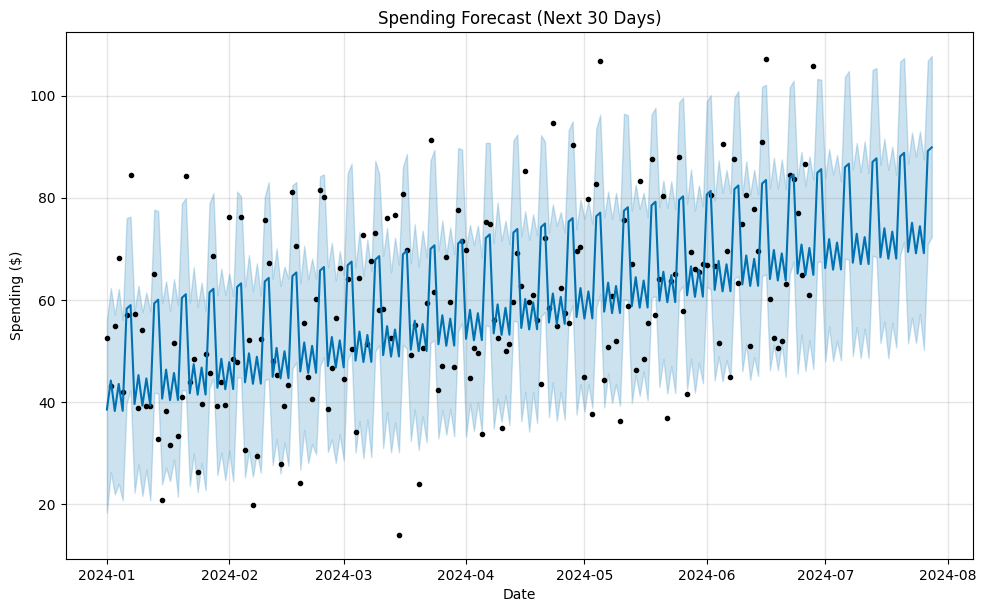

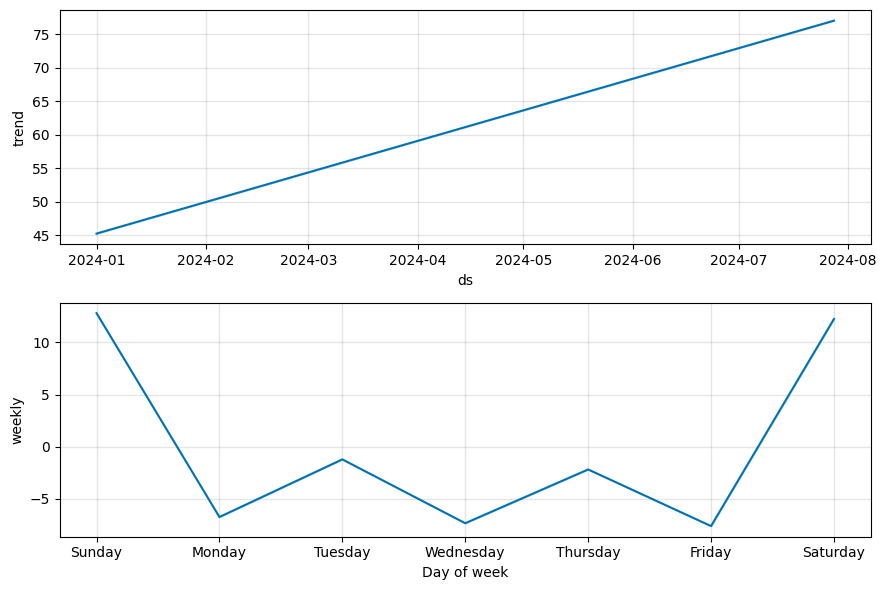

In [14]:
# --- 5. Plot the Results ---
print("Plotting forecast...")
# Prophet has a built-in plotting function
fig = model.plot(forecast)
plt.title('Spending Forecast (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Spending ($)')
plt.show()

# You can also view the components (trend and weekly pattern)
fig2 = model.plot_components(forecast)
plt.show()

In [23]:
# --- 5. Save Good Sample Data for API Testing ---

# We'll use the 'sample_spending_df' we created earlier, which has 180 days of good data
# It already has 'Date' and 'Amount' columns

# Create dummy V1-V28 columns (filled with 0s)
v_features = [f'V{i}' for i in range(1, 29)]
for col in v_features:
    sample_spending_df[col] = 0.0

# Add dummy Time, Class, id, Description
sample_spending_df['id'] = range(1, len(sample_spending_df) + 1)
sample_spending_df['Class'] = 0
sample_spending_df['Description'] = "Simulated Daily Spend"

# Convert 'Date' to the 'Time' (in seconds) format our API expects
start_date = sample_spending_df['Date'].min()
sample_spending_df['Time'] = (sample_spending_df['Date'] - start_date).dt.total_seconds()

# Define the final columns we want in our CSV
final_cols = ['id', 'Time'] + v_features + ['Amount', 'Class', 'Description']
final_df = sample_spending_df[final_cols]

# Save to a new CSV file
final_df.to_csv('good_forecast_sample.csv', index=False)

print("Saved 'good_forecast_sample.csv' with 180 days of data.")

Saved 'good_forecast_sample.csv' with 180 days of data.
